# Introduction to machine learning: assignment 3 - Logistic regression

In this assignment you are going to apply logistic regression methods to analyze a famous dataset on breast cancer prediction<sup>1</sup>: *breast_cancer.tsv*.

### Motivation
After skin cancer, breast cancer is the most common cancer diagnosed in women in western countries. Telling benign and malignant breast cancer apart is thus of paramount importance, yet very challenging: although there are combinations of cellular traits that characterize malignant cancer, there are no simple criteria for discriminating them exactly.
**Is there a way to successfully predict whether a skin cancer is benign or malignant?**

### Resources
The database proposed in this labwork collects 30 features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. The last column contains the corresponding diagnosis (benign=0, malignant=1).

### Aim
Our aim is to spatially separate (as much as possible) the distributions of benign and malignant breast cancers, and then fit a logistic regression able to predict if a cancer cell is benign or malign with maximum efficiency.

<sup>1</sup>This is a copy of [UCI ML Breast Cancer Wisconsin (Diagnostic) datasets](https://goo.gl/U2Uwz2).

## A. Loading and visualizing the dataset for two given classes

Import numpy and pandas, read in the dataset and print it. 
Be careful: this time the file is tab-separated, not comma-separated. Find the appropriate function argument to correctly parse the file.

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv('breast_cancer.tsv', sep='\t')
print(df)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mea

Verify the sizes of the features and outputs, check the feature names and their ranges (min and max of each feature)

Load the feature matrices $\mathbf{X}_0$, $\mathbf{X}_1$ and outputs $\mathbf{y}_0$, $\mathbf{y}_1$ for class 0 (benign) and class 1 (malignant) separately, and check their sizes

In [5]:
y_0=df.malignant[(df.malignant==0)]
X_0=df[(df.malignant==0)]
y_1=df.malignant[(df.malignant==1)]
X_1=df[(df.malignant==1)]
print(y_0.shape, y_1.shape)

(212,) (357,)


Now create a single feature matrix $\mathbf{X}$ and output vector $\mathbf{y}$ by concatenating the two matrices/vectors. Why is such a procedure useful?

In [8]:
y = np.vstack((y_0[:,None],y_1[:,None]))
X = np.vstack((X_0,X_1))

/Users/edoardosarti/programs/anaconda3/envs/sbl-demo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


Let's choose any two features - for example feature 1 and 4 - and try to plot them, coloring benign and malignant entries in two different colors. To do so, import pyplot (don't forget the magic "inline" command), and then use *scatter* to plot the two clouds. How do they look?

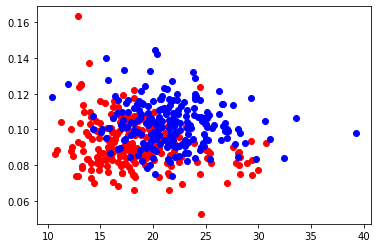

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X[len(y[y==1]):len(y),1],X[len(y[y==1]):len(y),4],c='r',label='Malignant');
plt.scatter(X[0:len(y[y==0]),1],X[0:len(y[y==0]),4],c='b',label='Benign');

Working with so many different features is hard: we need a way to visualize the data. Let's try with the most standard dimensionality reduction technique: principal component analysis (PCA).
Load the PCA package from sklearn, initialize a PCA object (set the dimensionality to 2!), then apply the *fit* and *transform* methods to obtain a matrix with only 2 columns (check it)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca=pca.transform(X)

Scatter plot the feature matrix (one feature for each axis), and color in two different colors the benign and malignant entries. Is it getting any better?

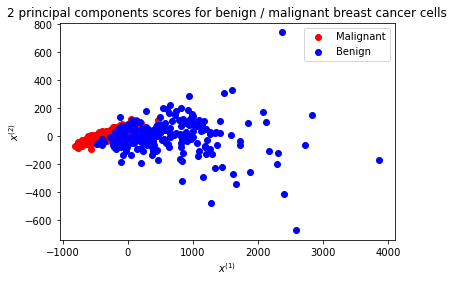

In [11]:
plt.scatter(X_pca[len(y[y==1]):len(y),0],X_pca[len(y[y==1]):len(y),1],c='r',label='Malignant');
plt.scatter(X_pca[0:len(y[y==0]),0],X_pca[0:len(y[y==0]),1],c='b',label='Benign');
plt.xlabel('$x^{(1)}$');
plt.ylabel('$x^{(2)}$');
plt.title('2 principal components scores for benign / malignant breast cancer cells')
plt.legend();

As we will see in the next labwork, machine learning techniques largely benefit from range standardization (i.e. transform your feature variables in order to have roughly the same range for each variable). The *preprocessing* module in sklearn contains the class *StandardScaler*. Use the *fit* method from this class for scaling the feature matrix. 

In [12]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Repeat the 2D PCA analysis and plot it. What do you find? Have we eventually managed to have two distributions that can be easily told apart?

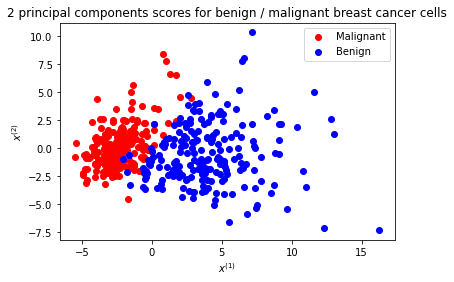

In [13]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca=pca.transform(X_scaled)
plt.scatter(X_pca[len(y[y==1]):len(y),0],X_pca[len(y[y==1]):len(y),1],c='r',label='Malignant');
plt.scatter(X_pca[0:len(y[y==0]),0],X_pca[0:len(y[y==0]),1],c='b',label='Benign');
plt.xlabel('$x^{(1)}$');
plt.ylabel('$x^{(2)}$');
plt.title('2 principal components scores for benign / malignant breast cancer cells')
plt.legend();

## B. Logistic regression

Import logistic regression from Scikit-learn (*linear_model*).

In [14]:
from sklearn import linear_model

Define a logistic regression model. There are two important attributes to consider: "*penalty*" defines the type of regularization of the model. We will keep the default L2 regularization here. "*C*" (positive float) defines the strength of the regularization. The smaller C, the stronger the regularization. Let's try with C=1e6  (a fairly small C = strong regularization).

*The logistic regression model implemented in Scikit-learn includes a regularization term on the l2-norm of β′ in order to avoid diverging solutions when solving the optimization problem corresponding to parameter learning. The parameter C divides this regularization term, so if you want to approximately test the standard logistic regression method (without regularization), you should set C to a high value (default is C=1.0).*

In [15]:
logistic = linear_model.LogisticRegression(penalty="l2", C=1e6)

Fit the logistic regression model to the 2D features, predict on the training data and compare with the training output labels.

In [16]:
logistic.fit(X_pca,np.ravel(y))
y_pred_logistic=logistic.predict(X_pca)
#print(np.hstack((y_pred_logistic.reshape(-1,1),y.reshape(-1,1))));

Evaluate the accuracy of the prediction on the training data with the fitted logistic regression model. Print the result. Does it correspond to the expected result?

In [17]:
acc_logistic = logistic.score(X_pca,np.ravel(y))
print('Accuracy of logistic regression: {}%'.format(acc_logistic*100))

Accuracy of logistic regression: 97.36379613356766%


By using the method *predict_proba* from logistic regression model and pyplot’s command *contour*, draw the separating line. 

The way to do it is simple: take the extrema of the domain of X (the min and max values of each feature), and make a grid covering all the domain. Evaluate the probability of each point (coordinate vector) of this grid with *predict_proba*. Once you have a grid of probabilities, you can use the *contour* command to plot the p = 0.5 separator.

Draw the scatter plot with the observations on the top of the separating line.

-5.610175496727185
[[-5.6101755  -5.50027911 -5.39038272 ... 16.03941333 16.14930972
  16.25920611]
 [-5.6101755  -5.50027911 -5.39038272 ... 16.03941333 16.14930972
  16.25920611]
 [-5.6101755  -5.50027911 -5.39038272 ... 16.03941333 16.14930972
  16.25920611]
 ...
 [-5.6101755  -5.50027911 -5.39038272 ... 16.03941333 16.14930972
  16.25920611]
 [-5.6101755  -5.50027911 -5.39038272 ... 16.03941333 16.14930972
  16.25920611]
 [-5.6101755  -5.50027911 -5.39038272 ... 16.03941333 16.14930972
  16.25920611]]
[9.93888538e-01 9.91720913e-01 9.88793140e-01 ... 2.27403802e-11
 1.67498980e-11 1.23374842e-11]


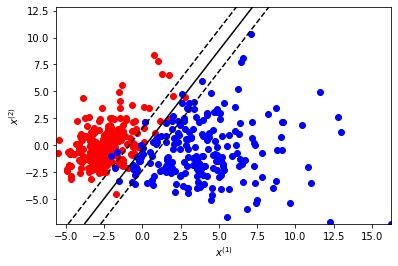

In [19]:
# Grid of values to draw decision line with contour plot 
x_1_min = np.min(X_pca[:, 0])
x_1_max = np.max(X_pca[:, 0])
x_2_min = np.min(X_pca[:, 1])
x_2_max = np.max(X_pca[:, 1])
print(x_1_min)
x_1_grid, x_2_grid = np.meshgrid(np.linspace(x_1_min,x_1_max,200),np.linspace(x_2_min,x_2_max,200))
print(x_1_grid)

# Probability of choosing class C_1
f = logistic.predict_proba(np.hstack((x_1_grid.reshape(-1,1),x_2_grid.reshape(-1,1))))[:,1]
print(f)

# Put the result into a color plot
f = f.reshape(np.shape(x_1_grid))
plt.contour(x_1_grid, x_2_grid, f,colors=['k','k','k'],levels=[0.05,0.5,0.95],linestyles=['--','-','--']);
plt.scatter(X_pca[len(y[y==1]):len(y),0],X_pca[len(y[y==1]):len(y),1],c='r',zorder=-1);
plt.scatter(X_pca[0:len(y[y==0]),0],X_pca[0:len(y[y==0]),1],c='b',zorder=-1);
plt.xlabel('$x^{(1)}$');
plt.ylabel('$x^{(2)}$');

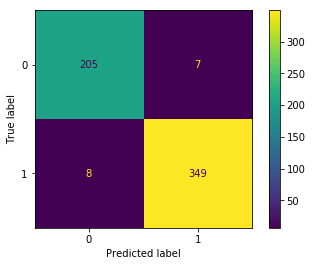

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y, y_pred_logistic, labels=logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic.classes_)
disp.plot();

## C. Different probability thresholds

Draw in the same picture the scatter plot of the dataset,the separating line from the previous exercise and the separating line obtained with threshold p = 0.2.
Generate the confusion matrix for the classifier obtained with p = 0.2 and comment on the results.

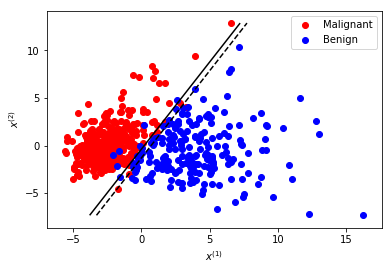

In [15]:
# Grid of values to draw decision line with contour plot 
x_1_min = np.min(X_pca[:, 0])
x_1_max = np.max(X_pca[:, 0])
x_2_min = np.min(X_pca[:, 1])
x_2_max = np.max(X_pca[:, 1])
x_1_grid, x_2_grid = np.meshgrid(np.linspace(x_1_min,x_1_max,200),np.linspace(x_2_min,x_2_max,200))

# Probability of choosing class C_1
f = logistic.predict_proba(np.hstack((x_1_grid.reshape(-1,1),x_2_grid.reshape(-1,1))))[:,1]

# Put the result into a color plot
f = f.reshape(np.shape(x_1_grid))
plt.contour(x_1_grid, x_2_grid, f,colors=['k','k'],levels=[0.2,0.5],linestyles=['--','-']);
plt.scatter(X_pca[len(y[y==0]):len(y),0],X_pca[len(y[y==0]):len(y),1],c='r',zorder=-1,
                                                            label='Malignant');
plt.scatter(X_pca[0:len(y[y==0]),0],X_pca[0:len(y[y==0]),1],c='b',zorder=-1,
                                                            label='Benign');
plt.xlabel('$x^{(1)}$');
plt.ylabel('$x^{(2)}$');
plt.legend();

Display the confusion matrix for p = 0.2

(569,)


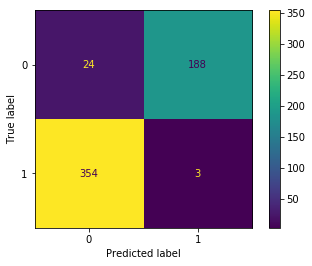

In [16]:
f = logistic.predict_proba(X_pca)[:,1]
print(np.shape(f))
y_pred_logistic[f>=0.2] = 0
y_pred_logistic[f<0.2] = 1
cm = confusion_matrix(y, y_pred_logistic, labels=logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic.classes_)
disp.plot();

Redo the previous item for p = 0.8 et p = 0.99.

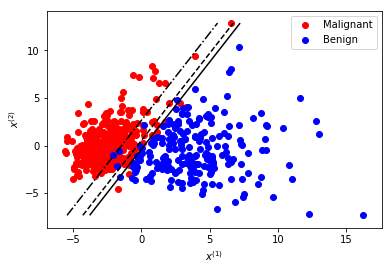

In [17]:
# Grid of values to draw decision line with contour plot 
x_1_min = np.min(X_pca[:, 0])
x_1_max = np.max(X_pca[:, 0])
x_2_min = np.min(X_pca[:, 1])
x_2_max = np.max(X_pca[:, 1])
x_1_grid, x_2_grid = np.meshgrid(np.linspace(x_1_min,x_1_max,200),np.linspace(x_2_min,x_2_max,200))

# Probability of choosing class C_1
f = logistic.predict_proba(np.hstack((x_1_grid.reshape(-1,1),x_2_grid.reshape(-1,1))))[:,1]

# Put the result into a color plot
f = f.reshape(np.shape(x_1_grid))
plt.contour(x_1_grid, x_2_grid, f,colors=['k','k'],levels=[0.5,0.8,0.99],linestyles=['-','--','-.']);
plt.scatter(X_pca[len(y[y==0]):len(y),0],X_pca[len(y[y==0]):len(y),1],c='r',zorder=-1,
                                                            label='Malignant');
plt.scatter(X_pca[0:len(y[y==0]),0],X_pca[0:len(y[y==0]),1],c='b',zorder=-1,
                                                            label='Benign');
plt.xlabel('$x^{(1)}$');
plt.ylabel('$x^{(2)}$');
plt.legend();

Display the confusion matrices for p = 0.8 and p = 0.99

(569,)
(569,)


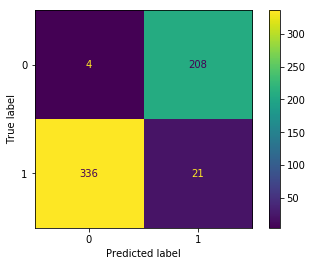

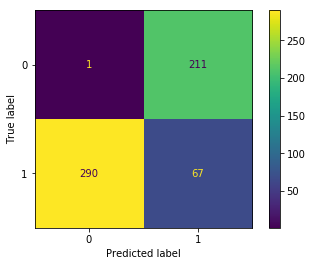

In [19]:
f = logistic.predict_proba(X_pca)[:,1]
print(np.shape(f))
y_pred_logistic[f>=0.8] = 0
y_pred_logistic[f<0.8] = 1
cm = confusion_matrix(y, y_pred_logistic, labels=logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic.classes_)
disp.plot();

f = logistic.predict_proba(X_pca)[:,1]
print(np.shape(f))
y_pred_logistic[f>=0.99] = 0
y_pred_logistic[f<0.99] = 1
cm = confusion_matrix(y, y_pred_logistic, labels=logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic.classes_)
disp.plot();

## D. Polynomial logistic regression

What if we didn't have that much information? Redefine the matrix X by only considering the first 3 features, redo the PCA as you did before (don't forget the scaling), and plot the scatter plot. How does it look? Make a linear regression and print the accuracy.

(212,) (357,)
Accuracy of logistic regression: 89.103690685413%


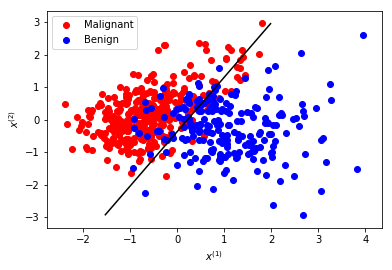

In [20]:
from sklearn.metrics import accuracy_score


y_0=df.malignant[(df.malignant==0)]
X_0=df[(df.malignant==0)].iloc[:,0:2]
y_1=df.malignant[(df.malignant==1)]
X_1=df[(df.malignant==1)].iloc[:,0:2]
print(y_0.shape, y_1.shape)

y = np.vstack((y_0[:,None],y_1[:,None]))
X = np.vstack((X_0,X_1))

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca=pca.transform(X_scaled)

logistic.fit(X_pca,np.ravel(y))
y_pred_logistic=logistic.predict(X_pca)

acc_logistic = accuracy_score(y,y_pred_logistic)
print('Accuracy of logistic regression: {}%'.format(acc_logistic*100))

# Grid of values to draw decision line with contour plot 
x_1_min = np.min(X_pca[:, 0])
x_1_max = np.max(X_pca[:, 0])
x_2_min = np.min(X_pca[:, 1])
x_2_max = np.max(X_pca[:, 1])
x_1_grid, x_2_grid = np.meshgrid(np.linspace(x_1_min,x_1_max,200),np.linspace(x_2_min,x_2_max,200))

# Probability of choosing class C_1
f = logistic.predict_proba(np.hstack((x_1_grid.reshape(-1,1),x_2_grid.reshape(-1,1))))[:,1]

# Put the result into a color plot
f = f.reshape(np.shape(x_1_grid))
plt.contour(x_1_grid, x_2_grid, f,colors=['k'],levels=[0.5],linestyles=['-']);
plt.scatter(X_pca[len(y[y==0]):len(y),0],X_pca[len(y[y==0]):len(y),1],c='r',zorder=-1,
                                                            label='Malignant');
plt.scatter(X_pca[0:len(y[y==0]),0],X_pca[0:len(y[y==0]),1],c='b',zorder=-1,
                                                            label='Benign');
plt.xlabel('$x^{(1)}$');
plt.ylabel('$x^{(2)}$');
plt.legend();

We can increase the accuracy by fitting a polynomial regression instead of a linear one. We will perform a trick that will be of great use in the following labworks: instead of switching from a linear to a polynomial regression, we will keep performing a linear regression, but applied on a transformed feature matrix. In order to pretend to fit an Nth-degree polynomial function, the first thing you have to do is thus defining a transformed matrix that contains all interaction terms between features up to the Nth degree. For example, for 2 features a and b, the 2nd degree interaction matrix will have the columns [a, b, a^2, ab, b^2]. Here, let's consider N=3.

Import the *PolynomialFeatures* class from *sklearn.preprocessing*, and define a polynomial transformation of degree 3. Make sure the new feature matrix has the right number of columns!

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_pca)

Now define the usual linear model. Limit the number of iterations to 1000. Then, use it to fit the new matrix, and calculate the accuracy. Is it better than the one of the simple linear regression?

In [22]:
logistic = linear_model.LogisticRegression(penalty="l2", C=1e6,max_iter=1000)
logistic.fit(X_poly,np.ravel(y))
y_pred_logistic=logistic.predict(X_poly)

acc_logistic = accuracy_score(y,y_pred_logistic)
print('Accuracy of logistic regression: {}%'.format(acc_logistic*100))

Accuracy of logistic regression: 91.03690685413005%


Lastly, plot the separator p = 0.5. How is this line expected to look?
In order to plot this line, we replicate the trick: this time, instead of transforming the matrix X, we will transform the usual grid before using *predict_proba*, then we will generate the contour as usual.

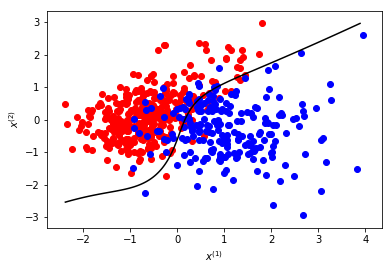

In [23]:
# Grid of values to draw decision line with contour plot 
x_1_min = np.min(X_pca[:, 0])
x_1_max = np.max(X_pca[:, 0])
x_2_min = np.min(X_pca[:, 1])
x_2_max = np.max(X_pca[:, 1])
x_1_grid, x_2_grid = np.meshgrid(np.linspace(x_1_min,x_1_max,200),np.linspace(x_2_min,x_2_max,200))

# Probability of choosing class C_1
f = logistic.predict_proba(poly.fit_transform(np.column_stack((x_1_grid.reshape(-1,1),
                                                               x_2_grid.reshape(-1,1)))))[:,1]

# Put the result into a color plot
f = f.reshape(np.shape(x_1_grid))
plt.contour(x_1_grid, x_2_grid, f,colors=['k'],levels=[0.5],linestyles=['-']);
plt.scatter(X_pca[len(y[y==0]):len(y),0],X_pca[len(y[y==0]):len(y),1],c='r',zorder=-1);
plt.scatter(X_pca[0:len(y[y==0]),0],X_pca[0:len(y[y==0]),1],c='b',zorder=-1);
plt.xlabel('$x^{(1)}$');
plt.ylabel('$x^{(2)}$');

Display the confusion matrix

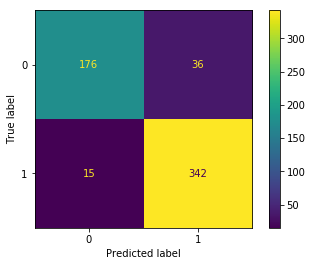

In [24]:
cm = confusion_matrix(y, y_pred_logistic, labels=logistic.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logistic.classes_)
disp.plot();

Do higher-degree polynomials fit even better? Make an analysis until degree = 20 and plot a degree vs. accuracy graph. What do you observe? What could be a good explanation for this effect? (Try to plot a high-degree case to confirm your hypothesis)

/Users/edoardosarti/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/edoardosarti/programs/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.o

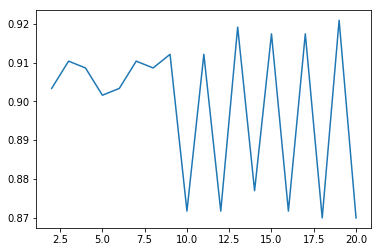

In [27]:
accs = []
for deg in range(2,21):
    poly = PolynomialFeatures(degree = deg, interaction_only=False, include_bias=False)
    X_poly = poly.fit_transform(X_pca)
    logistic = linear_model.LogisticRegression(penalty="l2", C=1e6,max_iter=1000)
    logistic.fit(X_poly,np.ravel(y))
    y_pred_logistic=logistic.predict(X_poly)
    acc_logistic = accuracy_score(y,y_pred_logistic)
    accs.append(acc_logistic)
    #print('Accuracy of logistic regression: {}%'.format(acc_logistic*100))
    
plt.plot(list(range(2,21)), accs)